name: longitude
value: 8911     0.4
11672   -0.9
9706    -0.0
15677   -1.4
345      1.3
        ... 
1603     1.2
14099   -1.2
5916     0.7
16959   -2.3
16430   -1.5
Name: longitude, Length: 17000, dtype: float64
name: latitude
value: 8911    -0.2
11672    1.4
9706     0.5
15677    1.0
345     -0.9
        ... 
1603    -0.8
14099    0.9
5916    -0.7
16959    2.5
16430    1.1
Name: latitude, Length: 17000, dtype: float64
name: housing_median_age
value: 8911    -0.2
11672   -0.8
9706    -0.8
15677    0.7
345     -1.2
        ... 
1603    -1.9
14099   -0.4
5916     0.5
16959   -0.7
16430    1.3
Name: housing_median_age, Length: 17000, dtype: float64
name: total_rooms
value: 8911    -0.5
11672    0.0
9706    -0.6
15677   -0.6
345     -0.2
        ... 
1603     3.0
14099   -0.3
5916     0.5
16959   -0.7
16430   -0.1
Name: total_rooms, Length: 17000, dtype: float64
name: total_bedrooms
value: 8911    -0.4
11672   -0.2
9706    -0.8
15677   -0.6
345     -0.3
        ... 
1603     1.9
14099   -

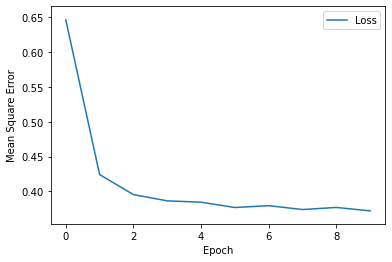

3000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [33]:
import numpy as np;
import pandas as pd;
import tensorflow as tf;
from tensorflow.keras import layers;
from matplotlib import pyplot as plt;
import seaborn as sns;

pd.options.display.max_rows = 10;
pd.options.display.float_format = "{:.1f}".format;

train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the examples
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# normalize
train_df_mean = train_df.mean();
train_df_std = train_df.std();
train_df_norm = (train_df - train_df_mean) / train_df_std;

test_df_mean = test_df.mean();
test_df_std = test_df.std();
test_df_norm = (test_df - test_df_mean) / test_df_std;

# 创建一个空数组，用于放置所有新创建的 feature columns
feature_columns = [];

resolution_in_Zs = 0.3; # 以 0.3 作为 bucket 的间隔

latitude_as_a_numeric_column = tf.feature_column.numeric_column('latitude'); # 创建新的 feature_column
latitude_boundaries = list(np.arange(
    int(min(train_df_norm['latitude'])),
    int(max(train_df_norm['latitude'])),
    resolution_in_Zs)); # 根据 latitude 取值范围的最大值、最小值、bucket 间隔划分 latitude 的 boundaries
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries); # bucketize 之后的 feature_column

longitude_as_a_numeric_column = tf.feature_column.numeric_column('longitude'); # 创建新的 feature_column
longitude_boundaries = list(np.arange(
    int(min(train_df_norm['longitude'])),
    int(max(train_df_norm['longitude'])),
    resolution_in_Zs)); # 根据 latitude 取值范围的最大值、最小值、bucket 间隔划分 latitude 的 boundaries
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, longitude_boundaries); # bucketize 之后的 feature_column

# 创建基于 latitude 和 longitude 的 feature cross
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size = 100);
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude);
feature_columns.append(crossed_feature);

median_income = tf.feature_column.numeric_column('median_income');
feature_columns.append(median_income);

population = tf.feature_column.numeric_column('population');
feature_columns.append(population);

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns);

# 画出 loss vs. epoch 图
def plot_the_loss_curve(epochs, mse):
    plt.figure();
    plt.xlabel('Epoch');
    plt.ylabel('Mean Square Error');
    
    plt.plot(epochs, mse, label = 'Loss');
    plt.legend();
    
    plt.ylim([mse.min()*0.95, mse.max()*1.03]);
    plt.show();


# 创建 Neural Network Model
def create_model(my_learning_rate, my_feature_layer):
    model = tf.keras.models.Sequential();

    model.add(my_feature_layer);
    
    # 第一隐层有 20 个 neuron，激活函数为 relu
    model.add(tf.keras.layers.Dense(units = 20,
                                    activation = 'relu',
                                    kernel_regularizer = tf.keras.regularizers.l2(l=0.01),
                                    name = 'Hidden1'));
    
    # 定义 dropout 层，用于避免过拟合，增强泛化能力
    model.add(tf.keras.layers.Dropout(rate = 0.25));
    
    
    # 第二隐层有 12 个 neuron，激活函数为 relu
    model.add(tf.keras.layers.Dense(units = 12,
                                    activation = 'relu',
                                    kernel_regularizer = tf.keras.regularizers.l2(l=0.01),
                                    name = 'Hidden2'));
    
    # 确定输出层
    model.add(tf.keras.layers.Dense(units = 1, name = 'Output'));
    
    # 设置模型训练过程使用的梯度下降方法、learning rate，metrics
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = my_learning_rate),
                  loss = 'mean_squared_error',
                  metrics = [tf.keras.metrics.MeanSquaredError()]);
    
    return model;

# 训练模型
def train_model(model, dataset, epochs, label_name, batch_size = None):
    features = {name: np.array(value) for name, value in dataset.items()};
    
    for name, value in dataset.items():
        print(f'name: {name}');
        print(f'value: {value}');
    
    label = np.array(features.pop(label_name));
    
    history = model.fit(x = features, y = label, epochs = epochs, batch_size = batch_size, shuffle = True);
    
    epochs = history.epoch;
    
    hist = pd.DataFrame(history.history);
    
    mse = hist['mean_squared_error'];
    
    return epochs, mse;

my_learning_rate = 0.01;
epochs = 10;
batch_size = 1000;

label_name = 'median_house_value';

my_model = create_model(my_learning_rate, my_feature_layer);

epochs, mse = train_model(my_model, train_df_norm, epochs, label_name, batch_size);

plot_the_loss_curve(epochs, mse);


# 检测在测试集的表现
test_features = {name: np.array(value) for name, value in test_df_norm.items()};
test_label = np.array(test_features.pop(label_name));
my_model.evaluate(x = test_features, y = test_label, batch_size = batch_size);
